In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [5]:
eth_data = pd.read_csv('BITSTAMP_ETHUSD, 1D_5e71b.csv')
eth_data['time'] = eth_data['time'].apply(lambda x: x.replace('T08:00:00+08:00', ''))
eth_data.set_index('time', inplace=True)
eth_data['HV'] = eth_data['HV'] * 0.01


IV = pd.read_csv('ETH_IV.csv')
IV['DateTime'] = IV['DateTime'].apply(lambda x: x.replace(' 00:00:00', ''))
IV.set_index('DateTime', inplace=True)
IV['ETH Volatility Index (DVOL)'] = IV['ETH Volatility Index (DVOL)'] * 0.01

In [8]:
backtest_period = ['2021-03-24', '2022-03-24']
ftest_period = ['2022-03-25', '2023-06-15']

HV_backtest_data = eth_data.loc[backtest_period[0]:backtest_period[1]]['HV']
HV_forward_data = eth_data.loc[ftest_period[0]:ftest_period[1]]['HV']

IV_backtest_data = IV.loc[backtest_period[0]:backtest_period[1]]['ETH Volatility Index (DVOL)']
IV_forward_data = IV.loc[ftest_period[0]:ftest_period[1]]['ETH Volatility Index (DVOL)']

In [9]:
def BB(data, rolling_window, std_multiplier):
    SMA = data.rolling(window=rolling_window).mean()
    std = data.rolling(window=rolling_window).std()
    lower_bound = SMA - std_multiplier*std
    upper_bound = SMA + std_multiplier*std
    
    return SMA, lower_bound, upper_bound

In [10]:
def VRP_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['ETH Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['ETH Volatility Index (DVOL)']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

Text(0.5, 1.0, 'Sharpe_ratio')

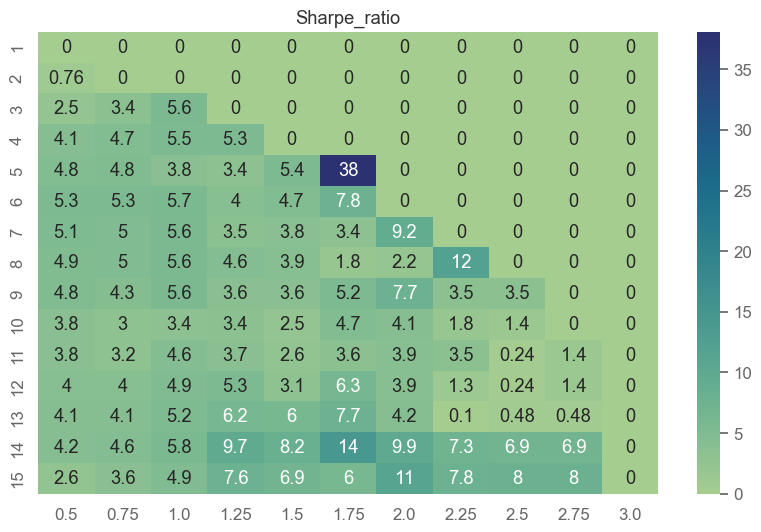

In [11]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})

ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

Text(0.5, 1.0, 'Sharpe_ratio')

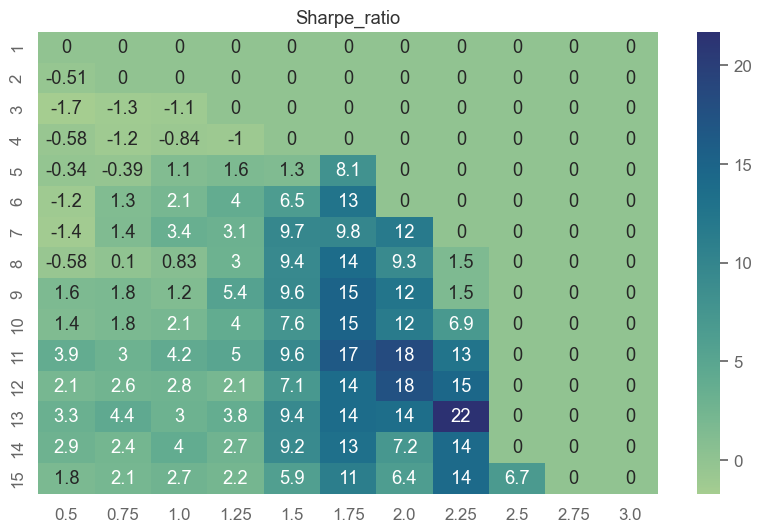

In [12]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_forward_data.index = pd.to_datetime(HV_forward_data.index)
        HV_forward_data.index = [time.strftime('%Y-%m-%d') for time in HV_forward_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})
        
ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

In [18]:
def VRP_BB_bound(df):

    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():

        last_index_condtion = date == df.index[-1]

        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['ETH Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['ETH Volatility Index (DVOL)']) 
            open_position = False

    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)

    profit = close_price - open_price
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_mean = np.mean(profit)

    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_mean = np.nan

    return winning_rate, freq, holding_median, profit_mean

In [19]:
# Tuning parameters
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [21]:
result_df[(result_df['rolling_window'] == 14)]

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
143,14,0.50,0.700000,20,4.0,0.012995
144,14,0.75,0.733333,15,6.0,0.015493
145,14,1.00,0.800000,15,5.0,0.022893
146,14,1.25,0.857143,14,4.0,0.044479
147,14,1.50,0.818182,11,5.0,0.042045
148,14,1.75,0.900000,10,6.0,0.078700
149,14,2.00,0.857143,7,5.0,0.067300
150,14,2.25,0.750000,4,6.0,0.073025
151,14,2.50,0.666667,3,9.0,0.086833
152,14,2.75,0.666667,3,9.0,0.086833


In [22]:
# forward_test 
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [23]:
result_df[(result_df['rolling_window'] == 14)]

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
143,14,0.50,0.625000,32,4.0,0.008147
144,14,0.75,0.592593,27,4.0,0.006985
145,14,1.00,0.640000,25,6.0,0.010920
146,14,1.25,0.578947,19,7.0,0.007137
147,14,1.50,0.631579,19,6.0,0.020879
148,14,1.75,0.692308,13,6.0,0.025069
149,14,2.00,0.571429,7,10.0,0.011957
150,14,2.25,0.750000,4,7.0,0.025950
151,14,2.50,0.000000,1,10.0,-0.034000
152,14,2.75,NaN,0,NaN,NaN


In [24]:
rolling_window_list = [14]
std_multiplier_list = [1.75]
winning_rate_list = []

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [25]:
df

,HV,ETH Volatility Index (DVOL),middle_band,upper_band,lower_band,VRP
2022-03-25,0.748849,0.7071,NaN,NaN,NaN,-0.041749
2022-03-26,0.749156,0.6854,NaN,NaN,NaN,-0.063756
2022-03-27,0.756363,0.7005,NaN,NaN,NaN,-0.055863
2022-03-28,0.754753,0.6899,NaN,NaN,NaN,-0.064853
2022-03-29,0.747793,0.7091,NaN,NaN,NaN,-0.038693
...,...,...,...,...,...,...
2023-06-11,0.469281,0.4426,-0.034830,0.004541,-0.074202,-0.026681
2023-06-12,0.452584,0.4479,-0.035956,-0.000407,-0.071504,-0.004684
2023-06-13,0.438670,0.4698,-0.033290,0.012447,-0.079026,0.031130
2023-06-14,0.454753,0.4383,-0.033004,0.013034,-0.079042,-0.016453
